# **Universidade Federal do Rio de Janeiro**
##Instituto de Matemática - DME
###Redes Neurais - Professor: Carlos Tadeu Pagani Zanini
####Grupo: Igor Nunes e Mariana Soares
#### Trabalho Final

**O objetivo deste trabalho é classificar as imagens da superfície de Vênus quanto à presença ou não de vulcões.**

In [2]:
# pacotes usuais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pacotes para importação dos dados
from google.colab import drive

# scikit image
from skimage.restoration import denoise_tv_chambolle
from skimage.morphology import reconstruction
from skimage import color, morphology
from skimage import feature

# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

# keras e tensorflow
import tensorflow as tf
import keras

# pacote para contar o tempo
from timeit import default_timer as timer

In [3]:
# criando conexão com o google drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [4]:
# imagens dos vulcões
feat = np.genfromtxt('/content/gdrive/MyDrive/UFRJ/UFRJ 2021.1/Redes Neurais/Trabalho final/features.csv', delimiter=",")

# variáveis respostas
resp = np.genfromtxt('/content/gdrive/MyDrive/UFRJ/UFRJ 2021.1/Redes Neurais/Trabalho final/responses.csv', delimiter=",",skip_header=1)

print("Shape das imagens")
print(feat.shape)

print("Shape das respostas")
print(resp.shape)

Shape das imagens
(7000, 12100)
Shape das respostas
(7000, 4)


In [5]:
# fazendo reshape das imagens
feat = feat.reshape((7000,110,110,1))
print(feat.shape)

(7000, 110, 110, 1)


In [6]:
# a primeira coluna da variável resp é a que diz se existe ou não vulcão na imagem
y = resp[:,0]

In [7]:
# divisão dos dados em treinamento e validação
X_train, X_valid, y_train, y_valid = train_test_split(feat, y, test_size=0.2, random_state=42, stratify=y)

print("Shape imagens de treino")
print(X_train.shape)
print("Shape imagens de validação")
print(X_valid.shape)

Shape imagens de treino
(5600, 110, 110, 1)
Shape imagens de validação
(1400, 110, 110, 1)


Podemos ver que, através da figura abaixo, estamos lidando com dados desbalanceados. Por isso é importante fazer a estratificação dos dados.

Proporção das imagens que possuem pelo menos um vulcão nos dados de treino
0.1429


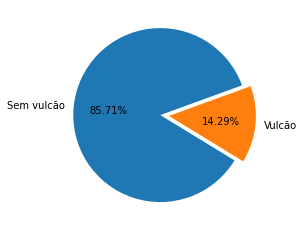

In [8]:
# proporção imagens que contém pelo menos um vulcão no conjunto de treino 
# (como usei o stratify para manter a mesma proporção, então será a mesma proporção do conjunto inteiro dos dados)
print("Proporção das imagens que possuem pelo menos um vulcão nos dados de treino")
print(round(y_train.sum()/len(y_train),4))
plot = plt.pie(x=np.array([(y_train==0.).sum(),(y_train==1.).sum()]),
               labels=["Sem vulcão","Vulcão"],
               explode=[0,0.1],
               startangle=20,
               autopct='%1.2f%%')

In [9]:
# mudando escala dos pixels para ficarem no intervalo [0,1]
X_train = X_train/255
X_valid = X_valid/255

## **MODELO 1 SEM REDUÇÃO DE RUÍDO(PRÉ-PROCESSAMENTO)**

- O modelo foi feito com 2 camadas convolucionais com **otimizador ADAM**;
- Primeira convolução: kernel (5,5) com 10 feature maps e ativação relu com padding = 'same' para manter dimensão do input;
- Primeiro MaxPooling de tamanho (4,4);
- Segunda convolução: kernel (5,5) com 10 feature maps e ativação relu com padding = 'same' para manter dimensão do input;
- Segundo MaxPooling de tamanho (4,4);

- Camada flat para entrar na rede neural completamente conectada;
- Primeira camada densa com 240 neurônios e ativação relu;
- Segunda camada densa com 120 neurônios e ativação relu;
- Terceira camada densa com 60 neurônios e ativação relu;
- Camada de output com ativação sigmoid.

In [10]:
# função do modelo
def create_model(threshold=0.5):
    modelo = tf.keras.models.Sequential()

    # primeira camada convolucional 
    modelo.add(tf.keras.layers.Conv2D(10, (5,5), activation='relu', padding="same", input_shape=(110,110,1), name='conv_1'))
    modelo.add(tf.keras.layers.MaxPooling2D( pool_size=(4,4), name='pooling_1' ))

    # segunda camada convolucional
    modelo.add(tf.keras.layers.Conv2D(10, (5,5), activation='relu', padding="same", name='conv_2'))
    modelo.add(tf.keras.layers.MaxPooling2D( pool_size=(4,4), name='pooling_2' ))

    # camada completamente conectada MLP
    modelo.add(tf.keras.layers.Flatten( name='Flatten' ))
    modelo.add(tf.keras.layers.Dense(240, activation='relu', name='Dense_1'))
    modelo.add(tf.keras.layers.Dense(120, activation='relu', name='Dense_2'))
    modelo.add(tf.keras.layers.Dense(60, activation='relu', name='Dense_3'))
    modelo.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output') )



    modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss="binary_crossentropy",
              metrics=['accuracy',tf.keras.metrics.Precision(thresholds=threshold,
                                                             name="Precision")])
    return modelo

O comando abaixo serve para criar pesos diferentes para cada classe. Assim, dando mais peso ao classificar erroneamente vulcões como não vulcões, garantimos que em um conjunto de dados desbalanceado como esse, o algoritmo não fique preso prevendo todas as observações como não vulcões.

In [11]:
# calculando pesos para as classes, pois são desbalanceadas
peso_classes = class_weight.compute_class_weight('balanced',
                                  np.unique(y_train),
                                  y_train)
peso_dict = {0:peso_classes[0],
             1:peso_classes[1]}

In [12]:
# cria o modelo 1: sem pré - processamento dos dados
modelo1 = create_model()

# sumário do modelo 1
modelo1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 110, 110, 10)      260       
_________________________________________________________________
pooling_1 (MaxPooling2D)     (None, 27, 27, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 27, 27, 10)        2510      
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 6, 6, 10)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 360)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 240)               86640     
_________________________________________________________________
Dense_2 (Dense)              (None, 120)               2

In [13]:
# fittando e guardando o history do modelo 1 com pesos diferentes para cada classe
history1 = modelo1.fit(x=X_train, 
            y=y_train, 
            epochs=50, 
            steps_per_epoch=20,
            validation_data=(X_valid,y_valid),
            class_weight=peso_dict)

Epoch 1/50
20/20 [==============================] - 37s 2s/step - loss: 0.6892 - accuracy: 0.6214 - Precision: 0.1670 - val_loss: 0.6840 - val_accuracy: 0.5750 - val_Precision: 0.2214
Epoch 2/50
20/20 [==============================] - 36s 2s/step - loss: 0.6674 - accuracy: 0.5439 - Precision: 0.1839 - val_loss: 0.5524 - val_accuracy: 0.8721 - val_Precision: 0.8182
Epoch 3/50
20/20 [==============================] - 35s 2s/step - loss: 0.6157 - accuracy: 0.7102 - Precision: 0.2733 - val_loss: 0.5579 - val_accuracy: 0.8693 - val_Precision: 0.5254
Epoch 4/50
20/20 [==============================] - 35s 2s/step - loss: 0.5190 - accuracy: 0.7745 - Precision: 0.3616 - val_loss: 0.4097 - val_accuracy: 0.9079 - val_Precision: 0.6310
Epoch 5/50
20/20 [==============================] - 35s 2s/step - loss: 0.3587 - accuracy: 0.8877 - Precision: 0.5753 - val_loss: 0.1907 - val_accuracy: 0.9329 - val_Precision: 0.8354
Epoch 6/50
20/20 [==============================] - 35s 2s/step - loss: 0.3218 -

##**PRÉ - PROCESSAMENTO**
Aqui foram usadas 4 técnicas de pré - processamento, para cada uma delas foram apresentadas 3 imagens contendo o antes e o depois após o uso de cada técnica. Foi usada uma técnica de redução de ruído, uma de encontrar picos, uma de reduzir objetos na escala de cinzas e uma para detectar bordas nessa ordem.

1.  **Reduzir ruídos:**  foi utilizado o método Total Variation denoising (TV);
2. **Encontrando picos:** escolhemos trabalhar com os picos encontrados, pois produziu resultados significativas nas imagens;
3. **Redução de objetos na escala de cinzas** escolhemos utilizar este pré-processamento pois ele deixa os traços das imagens bem fortes(como no MNIST)
4. **Edge Detection** é uma técnica de processamento de imagem usada para identificar os limites(bordas) de objetos ou regiões dentro de uma imagem

Os resultados estão expostos a seguir: 

In [14]:
# transformando as variáveis feat para dataframe para usar os métodos de redução de ruído
df_feat_flat = pd.DataFrame(feat.reshape((7000,12100)))/255

###**Reduzindo ruídos**

In [15]:
# localizadores de imagens com vulcões

# localizador para imagens com 1 vulcão
loc1 = np.where(resp[:,3]==1)[0]

# localizador para imagens com 2 vulcões
loc2 = np.where(resp[:,3]==2)[0]

# localizador para imagens com 3 vulcões
loc3 = np.where(resp[:,3]==3)[0]

# localizador para imagens com 4 vulcão
loc4 = np.where(resp[:,3]==4)[0]

# localizador para imagens com 5 vulcões
loc5 = np.where(resp[:,3]==5)[0]

Text(0.5, 1.0, 'Imagem com redução de ruído com 3 vulcões')

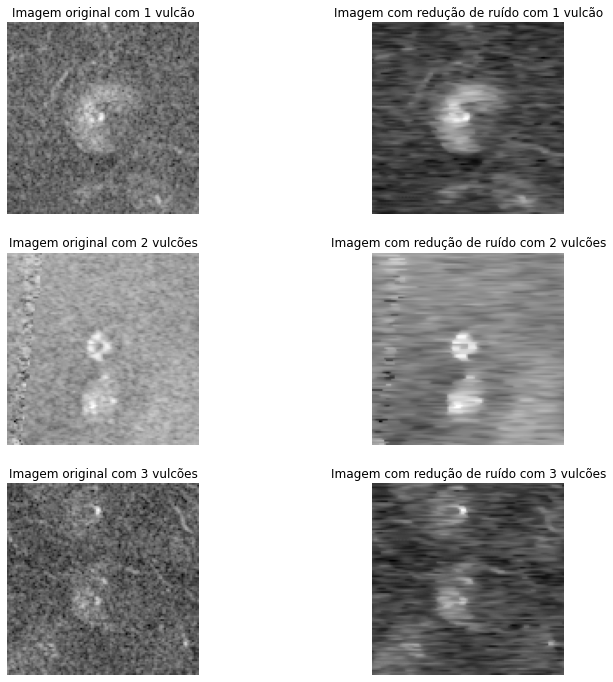

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12))

# imagem com 1 vulcão
ax[0,0].imshow(np.array(df_feat_flat.iloc[ loc1[1] ]).reshape((110,110)),cmap='gray')
ax[0,0].axis("off")
ax[0,0].set_title('Imagem original com 1 vulcão')

ax[0,1].imshow(np.array(denoise_tv_chambolle(df_feat_flat.iloc[ loc1[1] ])).reshape((110,110)),cmap='gray')
ax[0,1].axis("off")
ax[0,1].set_title('Imagem com redução de ruído com 1 vulcão')

# imagem com 2 vulcões
ax[1,0].imshow(np.array(df_feat_flat.iloc[ loc2[5] ]).reshape((110,110)),cmap='gray')
ax[1,0].axis("off")
ax[1,0].set_title('Imagem original com 2 vulcões')

ax[1,1].imshow(np.array(denoise_tv_chambolle(df_feat_flat.iloc[ loc2[5] ])).reshape((110,110)),cmap='gray')
ax[1,1].axis("off")
ax[1,1].set_title('Imagem com redução de ruído com 2 vulcões')

# imagem com 3 vulcões
ax[2,0].imshow(np.array(df_feat_flat.iloc[ loc3[3] ]).reshape((110,110)),cmap='gray')
ax[2,0].axis("off")
ax[2,0].set_title('Imagem original com 3 vulcões')

ax[2,1].imshow(np.array(denoise_tv_chambolle(df_feat_flat.iloc[ loc3[3] ])).reshape((110,110)),cmap='gray')
ax[2,1].axis("off")
ax[2,1].set_title('Imagem com redução de ruído com 3 vulcões')

In [17]:
# aplicando a técnica de redução de ruído em todas as imagens
df_feat_flat_sem_ruido = df_feat_flat.apply(func = denoise_tv_chambolle,axis=1)

###**Econtrando picos**

In [18]:
# Criando uma funcao finding peaks (encontra picos)
def funcao(linha):

    img = np.array(linha).reshape((110,110)) 
    
    mask = img

    seed = np.copy(img)

    seed[1:-1, 1:-1] = img.min()

    rec = reconstruction(seed, mask, method='dilation')

    return ((img-rec).ravel())


# Criando uma função top hat filter (remove pequenos objetos na escala de cinza)
def funcao_tophat(linha):

    image = np.array(linha).reshape((110,110))

    selem =  morphology.disk(2)
    
    res = morphology.white_tophat(image, selem)

    return ((image-res).ravel())



In [19]:
# Aplicando a funcao para encontrar picos
df_feat_flat_sem_ruido_finding_peaks = df_feat_flat_sem_ruido.apply(func=funcao,axis=1,result_type='broadcast')

Text(0.5, 1.0, 'Imagem da esquerda com finding peaks')

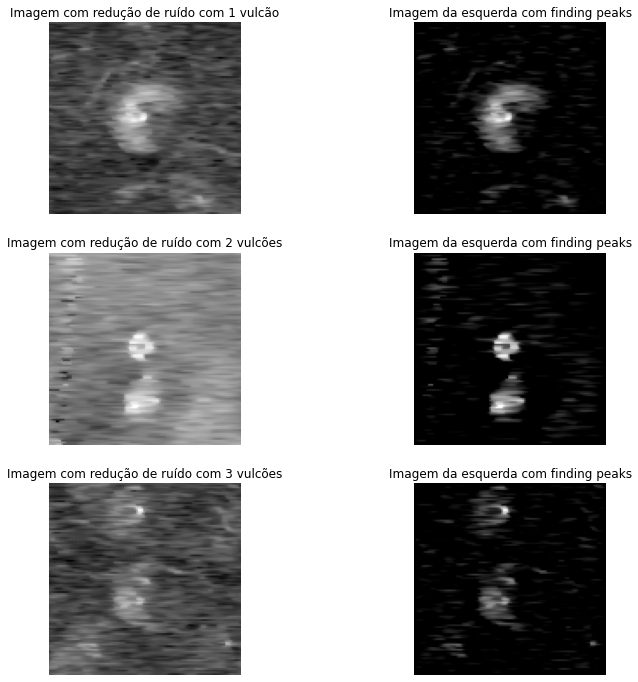

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12))

# imagem com 1 vulcão
ax[0,0].imshow(np.array(df_feat_flat_sem_ruido.iloc[ loc1[1] ]).reshape((110,110)),cmap='gray')
ax[0,0].axis("off")
ax[0,0].set_title('Imagem com redução de ruído com 1 vulcão')

ax[0,1].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks.iloc[ loc1[1] ]).reshape((110,110)),cmap='gray')
ax[0,1].axis("off")
ax[0,1].set_title('Imagem da esquerda com finding peaks')

# imagem com 2 vulcões
ax[1,0].imshow(np.array(df_feat_flat_sem_ruido.iloc[ loc2[5] ]).reshape((110,110)),cmap='gray')
ax[1,0].axis("off")
ax[1,0].set_title('Imagem com redução de ruído com 2 vulcões')

ax[1,1].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks.iloc[ loc2[5] ]).reshape((110,110)),cmap='gray')
ax[1,1].axis("off")
ax[1,1].set_title('Imagem da esquerda com finding peaks')

# imagem com 3 vulcões
ax[2,0].imshow(np.array(df_feat_flat_sem_ruido.iloc[ loc3[3] ]).reshape((110,110)),cmap='gray')
ax[2,0].axis("off")
ax[2,0].set_title('Imagem com redução de ruído com 3 vulcões')

ax[2,1].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks.iloc[ loc3[3] ]).reshape((110,110)),cmap='gray')
ax[2,1].axis("off")
ax[2,1].set_title('Imagem da esquerda com finding peaks')

###**Redução de objetos na escala de cinzas**

In [21]:
# aplicando a função para remover pequenos objetos na escala de cinzas
df_feat_flat_sem_ruido_finding_peaks_tophat = df_feat_flat_sem_ruido_finding_peaks.apply(func = funcao_tophat,axis=1,result_type='broadcast')

Text(0.5, 1.0, 'Após remoção de objetos na escala de cinzas')

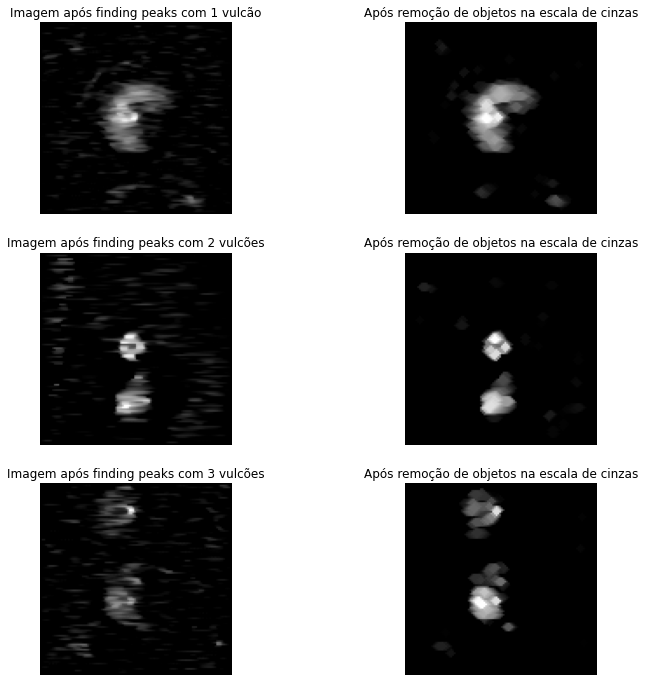

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12))

# imagem com 1 vulcão
ax[0,0].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks.iloc[ loc1[1] ]).reshape((110,110)),cmap='gray')
ax[0,0].axis("off")
ax[0,0].set_title('Imagem após finding peaks com 1 vulcão')

ax[0,1].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks_tophat.iloc[ loc1[1] ]).reshape((110,110)),cmap='gray')
ax[0,1].axis("off")
ax[0,1].set_title('Após remoção de objetos na escala de cinzas')

# imagem com 2 vulcões
ax[1,0].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks.iloc[ loc2[5] ]).reshape((110,110)),cmap='gray')
ax[1,0].axis("off")
ax[1,0].set_title('Imagem após finding peaks com 2 vulcões')

ax[1,1].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks_tophat.iloc[ loc2[5] ]).reshape((110,110)),cmap='gray')
ax[1,1].axis("off")
ax[1,1].set_title('Após remoção de objetos na escala de cinzas')

# imagem com 3 vulcões
ax[2,0].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks.iloc[ loc3[3] ]).reshape((110,110)),cmap='gray')
ax[2,0].axis("off")
ax[2,0].set_title('Imagem após finding peaks com 3 vulcões')

ax[2,1].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks_tophat.iloc[ loc3[3] ]).reshape((110,110)),cmap='gray')
ax[2,1].axis("off")
ax[2,1].set_title('Após remoção de objetos na escala de cinzas')

###**Edge Detector**

In [23]:
# Criando uma função edge detector
def edge_detector(linha):

    image = np.array(linha).reshape((110,110))

    edges =  feature.canny(image,
                           sigma=0.001,
                           low_threshold=0.005)

    return (edges.ravel())

In [24]:
# aplicando o edge detector as imagens
df_feat_flat_sem_ruido_finding_peaks_tophat_edge_detector = df_feat_flat_sem_ruido_finding_peaks_tophat.apply(func=edge_detector,axis=1,result_type='broadcast')

Text(0.5, 1.0, 'Após remoção de objetos na escala de cinzas')

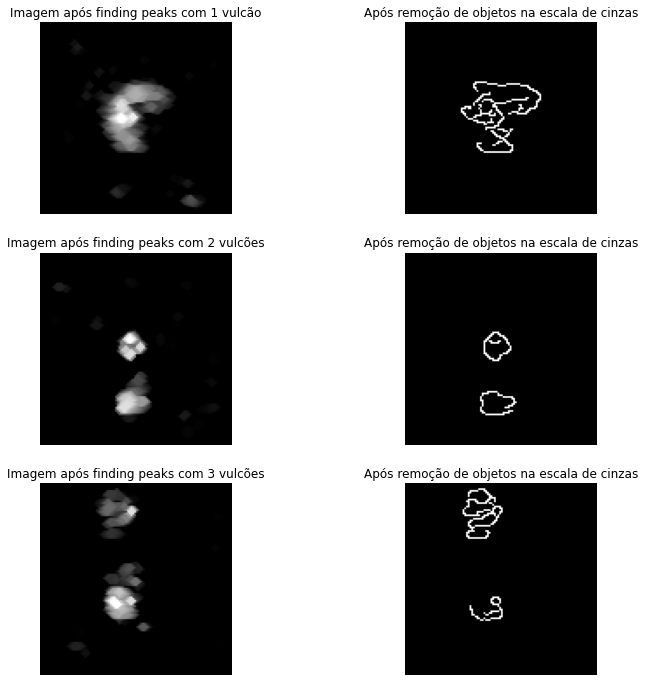

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12))

# imagem com 1 vulcão
ax[0,0].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks_tophat.iloc[ loc1[1] ]).reshape((110,110)),cmap='gray')
ax[0,0].axis("off")
ax[0,0].set_title('Imagem após finding peaks com 1 vulcão')

ax[0,1].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks_tophat_edge_detector.iloc[ loc1[1] ]).reshape((110,110)),cmap='gray')
ax[0,1].axis("off")
ax[0,1].set_title('Após remoção de objetos na escala de cinzas')

# imagem com 2 vulcões
ax[1,0].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks_tophat.iloc[ loc2[5] ]).reshape((110,110)),cmap='gray')
ax[1,0].axis("off")
ax[1,0].set_title('Imagem após finding peaks com 2 vulcões')

ax[1,1].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks_tophat_edge_detector.iloc[ loc2[5] ]).reshape((110,110)),cmap='gray')
ax[1,1].axis("off")
ax[1,1].set_title('Após remoção de objetos na escala de cinzas')

# imagem com 3 vulcões
ax[2,0].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks_tophat.iloc[ loc3[3] ]).reshape((110,110)),cmap='gray')
ax[2,0].axis("off")
ax[2,0].set_title('Imagem após finding peaks com 3 vulcões')

ax[2,1].imshow(np.array(df_feat_flat_sem_ruido_finding_peaks_tophat_edge_detector.iloc[ loc3[3] ]).reshape((110,110)),cmap='gray')
ax[2,1].axis("off")
ax[2,1].set_title('Após remoção de objetos na escala de cinzas')

##**MODELO 2 - APLICANDO O MODELO 1 APÓS O PRÉ-PROCESSAMENTO DOS DADOS**

O modelo 2 é apenas a aplicação do modelo 1 após o pré-processamento das imagens.

In [26]:
X_pp = df_feat_flat_sem_ruido_finding_peaks_tophat_edge_detector.to_numpy().reshape((7000,110,110,1))

In [27]:
# separando os dados pré - processados para treinamento e validação
X_train_pp, X_valid_pp, y_train_pp, y_valid_pp = train_test_split(X_pp, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
# criando o modelo para aplicar aos dados pré - processados
modelo2 = create_model()
modelo2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 110, 110, 10)      260       
_________________________________________________________________
pooling_1 (MaxPooling2D)     (None, 27, 27, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 27, 27, 10)        2510      
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 6, 6, 10)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 360)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 240)               86640     
_________________________________________________________________
Dense_2 (Dense)              (None, 120)              

In [29]:
# fittando e guardando o history do modelo 2 com pesos diferentes para cada classe para os dados pré - processados
history2 = modelo2.fit(x=X_train_pp, 
            y=y_train_pp, 
            epochs=50, 
            steps_per_epoch=20,
            validation_data=(X_valid_pp,y_valid_pp),
            class_weight=peso_dict)

Epoch 1/50
20/20 [==============================] - 36s 2s/step - loss: 0.5811 - accuracy: 0.7511 - Precision: 0.3146 - val_loss: 0.5750 - val_accuracy: 0.8593 - val_Precision: 0.5061
Epoch 2/50
20/20 [==============================] - 34s 2s/step - loss: 0.4857 - accuracy: 0.8795 - Precision: 0.5731 - val_loss: 0.4752 - val_accuracy: 0.8686 - val_Precision: 0.5342
Epoch 3/50
20/20 [==============================] - 34s 2s/step - loss: 0.4604 - accuracy: 0.9004 - Precision: 0.6649 - val_loss: 0.4422 - val_accuracy: 0.9100 - val_Precision: 0.7176
Epoch 4/50
20/20 [==============================] - 34s 2s/step - loss: 0.4441 - accuracy: 0.9114 - Precision: 0.7249 - val_loss: 0.4137 - val_accuracy: 0.9043 - val_Precision: 0.6793
Epoch 5/50
20/20 [==============================] - 34s 2s/step - loss: 0.4285 - accuracy: 0.9170 - Precision: 0.7511 - val_loss: 0.4160 - val_accuracy: 0.9086 - val_Precision: 0.7045
Epoch 6/50
20/20 [==============================] - 34s 2s/step - loss: 0.4175 -

##**MODELO 3 - APLICANDO APÓS O PRÉ-PROCESSAMENTO DOS DADOS**

- O modelo foi feito com 2 camadas convolucionais com **otimizador RMSprop**(única diferença para os modelos 1 e 2)
- Primeira convolução: kernel (5,5) com 10 feature maps e ativação relu com padding = 'same' para manter dimensão do input;
- Primeiro MaxPooling de tamanho (4,4);
- Segunda convolução: kernel (5,5) com 10 feature maps e ativação relu com padding = 'same' para manter dimensão do input;
- Segundo MaxPooling de tamanho (4,4);

- Camada flat para entrar na rede neural completamente conectada;
- Primeira camada densa com 240 neurônios e ativação relu;
- Segunda camada densa com 120 neurônios e ativação relu;
- Terceira camada densa com 60 neurônios e ativação relu;
- Camada de output com ativação sigmoid.

In [30]:
# função do modelo com RMSprop
def model_RMSprop(threshold=0.5):
    modelo = tf.keras.models.Sequential()

    # primeira camada convolucional 
    modelo.add(tf.keras.layers.Conv2D(10, (5,5), activation='relu', padding="same", input_shape=(110,110,1), name='conv_1'))
    modelo.add(tf.keras.layers.MaxPooling2D( pool_size=(4,4), name='pooling_1' ))

    # segunda camada convolucional
    modelo.add(tf.keras.layers.Conv2D(10, (5,5), activation='relu', padding="same", name='conv_2'))
    modelo.add(tf.keras.layers.MaxPooling2D( pool_size=(4,4), name='pooling_2' ))

    # camada completamente conectada MLP
    modelo.add(tf.keras.layers.Flatten( name='Flatten' ))
    modelo.add(tf.keras.layers.Dense(240, activation='relu', name='Dense_1'))
    modelo.add(tf.keras.layers.Dense(120, activation='relu', name='Dense_2'))
    modelo.add(tf.keras.layers.Dense(60, activation='relu', name='Dense_3'))
    modelo.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output') )



    modelo.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.001),
              loss="binary_crossentropy",
              metrics=['accuracy',tf.keras.metrics.Precision(thresholds=threshold,
                                                             name="Precision")])
    return modelo

In [31]:
# cria o modelo
modelo3 = model_RMSprop()

# sumário do modelo
modelo3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 110, 110, 10)      260       
_________________________________________________________________
pooling_1 (MaxPooling2D)     (None, 27, 27, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 27, 27, 10)        2510      
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 6, 6, 10)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 360)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 240)               86640     
_________________________________________________________________
Dense_2 (Dense)              (None, 120)              

In [32]:
# fittando e guardando o history do modelo
history3 = modelo3.fit(x=X_train_pp, 
            y=y_train_pp, 
            epochs=50, 
            steps_per_epoch=20,
            validation_data=(X_valid_pp,y_valid_pp),
            class_weight=peso_dict)

Epoch 1/50
20/20 [==============================] - 36s 2s/step - loss: 0.5335 - accuracy: 0.8304 - Precision: 0.4330 - val_loss: 0.6181 - val_accuracy: 0.8300 - val_Precision: 0.4345
Epoch 2/50
20/20 [==============================] - 34s 2s/step - loss: 0.4758 - accuracy: 0.8909 - Precision: 0.6192 - val_loss: 0.4999 - val_accuracy: 0.8750 - val_Precision: 0.5551
Epoch 3/50
20/20 [==============================] - 35s 2s/step - loss: 0.4599 - accuracy: 0.9029 - Precision: 0.6783 - val_loss: 0.4196 - val_accuracy: 0.8986 - val_Precision: 0.6543
Epoch 4/50
20/20 [==============================] - 34s 2s/step - loss: 0.4451 - accuracy: 0.9105 - Precision: 0.7170 - val_loss: 0.4654 - val_accuracy: 0.9043 - val_Precision: 0.6854
Epoch 5/50
20/20 [==============================] - 34s 2s/step - loss: 0.4419 - accuracy: 0.9141 - Precision: 0.7349 - val_loss: 0.4008 - val_accuracy: 0.9114 - val_Precision: 0.7289
Epoch 6/50
20/20 [==============================] - 34s 2s/step - loss: 0.4289 -

##**MODELO 4 - APLICANDO TAMBÉM AOS DADOS PRÉ-PROCESSADOS**



- O modelo foi feito com 2 camadas convolucionais e **otimizador Adam** como nos modelos primeiros modelos;
- Primeira convolução: kernel (8,8) com 10 feature maps e ativação relu com padding = 'same' para manter dimensão do input;
- Primeiro MaxPooling de tamanho (4,4);
- Segunda convolução: kernel (8,8) com 10 feature maps e ativação relu com padding = 'same' para manter dimensão do input;
- Segundo MaxPooling de tamanho (4,4);

- Camada flat para entrar na rede neural completamente conectada;
- Primeira camada densa com 240 neurônios e ativação relu;
- Segunda camada densa com 120 neurônios e ativação relu;
- Terceira camada densa com 60 neurônios e ativação relu;
- Camada de output com ativação sigmoid.

In [33]:
# função do modelo com Adam
def model_Adam(threshold=0.5):
    modelo = tf.keras.models.Sequential()

    # primeira camada convolucional 
    modelo.add(tf.keras.layers.Conv2D(10, (8,8), activation='relu', padding="same", input_shape=(110,110,1), name='conv_1'))
    modelo.add(tf.keras.layers.MaxPooling2D( pool_size=(4,4), name='pooling_1' ))

    # segunda camada convolucional
    modelo.add(tf.keras.layers.Conv2D(10, (8,8), activation='relu', padding="same", name='conv_2'))
    modelo.add(tf.keras.layers.MaxPooling2D( pool_size=(4,4), name='pooling_2' ))

    # camada completamente conectada MLP
    modelo.add(tf.keras.layers.Flatten( name='Flatten' ))
    modelo.add(tf.keras.layers.Dense(240, activation='relu', name='Dense_1'))
    modelo.add(tf.keras.layers.Dense(120, activation='relu', name='Dense_2'))
    modelo.add(tf.keras.layers.Dense(60, activation='relu', name='Dense_3'))
    modelo.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output') )



    modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss="binary_crossentropy",
              metrics=['accuracy',tf.keras.metrics.Precision(thresholds=threshold,
                                                             name="Precision")])
    return modelo

In [34]:
modelo4 = model_Adam()
modelo4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 110, 110, 10)      650       
_________________________________________________________________
pooling_1 (MaxPooling2D)     (None, 27, 27, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 27, 27, 10)        6410      
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 6, 6, 10)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 360)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 240)               86640     
_________________________________________________________________
Dense_2 (Dense)              (None, 120)              

In [35]:
history4 = modelo4.fit(x=X_train_pp, 
            y=y_train_pp, 
            epochs=50, 
            steps_per_epoch=20,
            validation_data=(X_valid_pp,y_valid_pp),
            class_weight=peso_dict)

Epoch 1/50
20/20 [==============================] - 66s 3s/step - loss: 0.5962 - accuracy: 0.6384 - Precision: 0.2410 - val_loss: 0.6305 - val_accuracy: 0.8514 - val_Precision: 0.4845
Epoch 2/50
20/20 [==============================] - 64s 3s/step - loss: 0.4962 - accuracy: 0.8845 - Precision: 0.5925 - val_loss: 0.4158 - val_accuracy: 0.8957 - val_Precision: 0.6467
Epoch 3/50
20/20 [==============================] - 64s 3s/step - loss: 0.4644 - accuracy: 0.9004 - Precision: 0.6667 - val_loss: 0.4366 - val_accuracy: 0.8979 - val_Precision: 0.6492
Epoch 4/50
20/20 [==============================] - 64s 3s/step - loss: 0.4497 - accuracy: 0.9061 - Precision: 0.6924 - val_loss: 0.4107 - val_accuracy: 0.9071 - val_Precision: 0.6966
Epoch 5/50
20/20 [==============================] - 64s 3s/step - loss: 0.4404 - accuracy: 0.9127 - Precision: 0.7311 - val_loss: 0.4305 - val_accuracy: 0.9036 - val_Precision: 0.6796
Epoch 6/50
20/20 [==============================] - 64s 3s/step - loss: 0.4330 -

##**MODELO 5 - APLICANDO TAMBÉM AOS DADOS PRÉ-PROCESSADOS**

- O modelo foi feito com 3 camadas convolucionais e **otimizador Adam**;
- Primeira convolução: kernel (8,8) com 10 feature maps e ativação relu com padding = 'same' para manter dimensão do input;
- Primeiro MaxPooling de tamanho (4,4);
- Segunda convolução: kernel (8,8) com 10 feature maps e ativação relu com padding = 'same' para manter dimensão do input;
- Segundo MaxPooling de tamanho (4,4);
- Terceira convolução: kernel (8,8) com 10 feature maps e ativação relu com padding = 'same' para manter dimensão do input;
- Terceiro MaxPooling de tamanho (4,4);

- Camada flat para entrar na rede neural completamente conectada;
- Primeira camada densa com 240 neurônios e ativação relu;
- Segunda camada densa com 120 neurônios e ativação relu;
- Terceira camada densa com 60 neurônios e ativação relu;
- Camada de output com ativação sigmoid.

In [36]:
# função do modelo com Adam
def model_Adam2(threshold=0.5):
    modelo = tf.keras.models.Sequential()

    # primeira camada convolucional 
    modelo.add(tf.keras.layers.Conv2D(10, (8,8), activation='relu', padding="same", input_shape=(110,110,1), name='conv_1'))
    modelo.add(tf.keras.layers.MaxPooling2D( pool_size=(4,4), name='pooling_1' ))

    # segunda camada convolucional 
    modelo.add(tf.keras.layers.Conv2D(10, (8,8), activation='relu', padding="same", input_shape=(110,110,1), name='conv_2'))
    modelo.add(tf.keras.layers.MaxPooling2D( pool_size=(4,4), name='pooling_2' ))

    # terceira camada convolucional
    modelo.add(tf.keras.layers.Conv2D(10, (8,8), activation='relu', padding="same", name='conv_3'))
    modelo.add(tf.keras.layers.MaxPooling2D( pool_size=(4,4), name='pooling_3' ))

    # camada completamente conectada MLP
    modelo.add(tf.keras.layers.Flatten( name='Flatten' ))
    modelo.add(tf.keras.layers.Dense(240, activation='relu', name='Dense_1'))
    modelo.add(tf.keras.layers.Dense(120, activation='relu', name='Dense_2'))
    modelo.add(tf.keras.layers.Dense(60, activation='relu', name='Dense_3'))
    modelo.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output') )



    modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss="binary_crossentropy",
              metrics=['accuracy',tf.keras.metrics.Precision(thresholds=threshold,
                                                             name="Precision")])
    return modelo

In [37]:
modelo5 = model_Adam2()
modelo5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 110, 110, 10)      650       
_________________________________________________________________
pooling_1 (MaxPooling2D)     (None, 27, 27, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 27, 27, 10)        6410      
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 6, 6, 10)          0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 6, 6, 10)          6410      
_________________________________________________________________
pooling_3 (MaxPooling2D)     (None, 1, 1, 10)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 10)               

In [38]:
history5 = modelo5.fit(x=X_train_pp, 
            y=y_train_pp, 
            epochs=50, 
            steps_per_epoch=20,
            validation_data=(X_valid_pp,y_valid_pp),
            class_weight=peso_dict)

Epoch 1/50
20/20 [==============================] - 67s 3s/step - loss: 0.6517 - accuracy: 0.6627 - Precision: 0.2515 - val_loss: 0.6893 - val_accuracy: 0.6871 - val_Precision: 0.2629
Epoch 2/50
20/20 [==============================] - 65s 3s/step - loss: 0.5477 - accuracy: 0.8064 - Precision: 0.3913 - val_loss: 0.5449 - val_accuracy: 0.8443 - val_Precision: 0.4664
Epoch 3/50
20/20 [==============================] - 65s 3s/step - loss: 0.4801 - accuracy: 0.8886 - Precision: 0.6078 - val_loss: 0.4388 - val_accuracy: 0.8821 - val_Precision: 0.5822
Epoch 4/50
20/20 [==============================] - 65s 3s/step - loss: 0.4650 - accuracy: 0.8957 - Precision: 0.6429 - val_loss: 0.3951 - val_accuracy: 0.9021 - val_Precision: 0.6780
Epoch 5/50
20/20 [==============================] - 65s 3s/step - loss: 0.4610 - accuracy: 0.9002 - Precision: 0.6626 - val_loss: 0.4093 - val_accuracy: 0.8936 - val_Precision: 0.6321
Epoch 6/50
20/20 [==============================] - 65s 3s/step - loss: 0.4439 -

##**ENSEMBLE DOS MODELOS 3, 4 E 5**

In [39]:
# somando as probabilidades de previsão dos modelos
prob_vulcao_ensemble = modelo3.predict(X_valid_pp) + modelo4.predict(X_valid_pp) + modelo5.predict(X_valid_pp)
prob_not_vulcao_ensemble = 3 - prob_vulcao_ensemble

# criando um arary onde a primeira coluna é a probablidade de não ter vulcão e a segunda coluna é a probabilidade de ter vulcão
predict_ensemble = np.c_[prob_not_vulcao_ensemble, prob_vulcao_ensemble]

# argmax pega a posição por linha onde o valor é maximo (mesmo valor do dígito), equal compara entrada a entrada da previsão e do y_test e retorna true ou false (0 ou 1) e mean calcula a média (acurácia) no conjunto de teste
print('Acurácia do ensemble: ' , np.mean(np.equal(np.argmax(predict_ensemble , axis = 1) , y_valid_pp)))

Acurácia do ensemble:  0.9285714285714286


A acurácia do ensemble não melhorou a previsão das observaçoes no conjunto de validação. Na verdade, até piorou, pois a acurácia na validação do modelo 4 foi 0.9286, ou seja, melhor que a acurácia no ensemble. Sendo assim, será melhor escolher o modelo 4 ao modelo ensemble, pois além da maior acurácia, também possui menos parâmetros.

##**PERFORMANCE DOS MODELOS**##

In [40]:
dict_history_models = {"Épocas":np.r_[np.arange(50), 
                                      np.arange(50), 
                                      np.arange(50), 
                                      np.arange(50), 
                                      np.arange(50)],
                       "Acurácia Validação":np.r_[history1.history['val_accuracy'], 
                                                  history2.history['val_accuracy'],
                                                  history3.history['val_accuracy'],
                                                  history4.history['val_accuracy'],
                                                  history5.history['val_accuracy']],
                       "Precisão Validação":np.r_[history1.history['val_Precision'],
                                                  history2.history['val_Precision'],
                                                  history3.history['val_Precision'],
                                                  history4.history['val_Precision'],
                                                  history5.history['val_Precision']],
                       "Legenda":np.r_[np.repeat("Modelo 1(sem pré-processamento Adam, 2 Conv. kernel (5,5))",50),
                                       np.repeat("Modelo 2(com pré-processamento Adam, 2 Conv. kernel (5,5))",50),
                                       np.repeat("Modelo 3(com pré-processamento RMSprop, 2 Conv. kernel (5,5))",50),
                                       np.repeat("Modelo 4(com pré-processamento Adam, 2 Conv. kernel (8,8))",50),
                                       np.repeat("Modelo 5(com pré-processamento Adam, 3 Conv. kernel (8,8))",50)]}

In [41]:
# criando um dataframe para plotar os gráficos com seaborn
df_history_modelos = pd.DataFrame(dict_history_models)

Text(0.5, 1.0, 'Acurácia na validação')

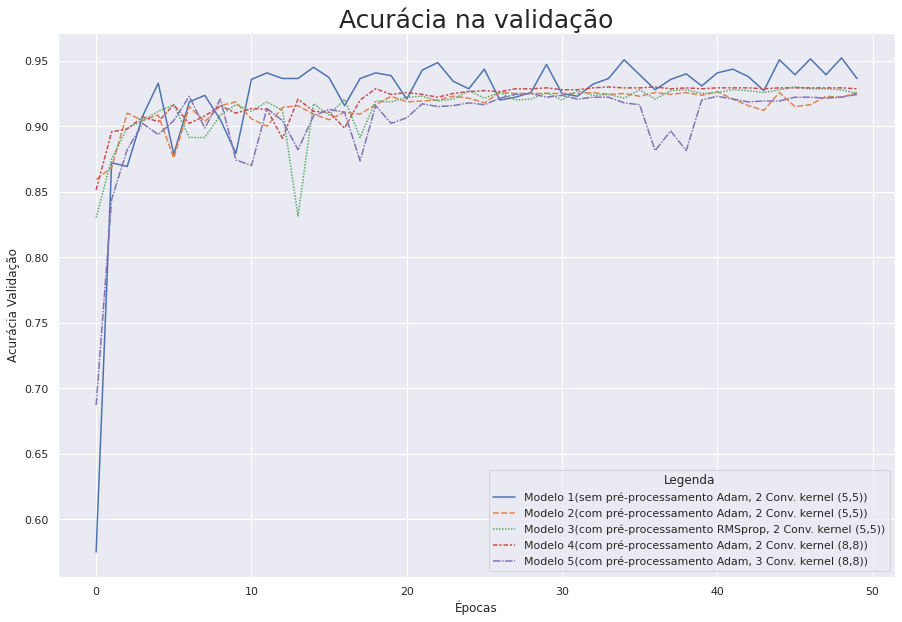

In [42]:
# mudando o tamanho da figura do seaborn
sns.set(rc={'figure.figsize':(15,10)})

# plotando o gráfico das acurácias no treino
sns.lineplot(data = df_history_modelos,
             x = 'Épocas', 
             y = 'Acurácia Validação',
             hue = 'Legenda',
             style='Legenda').set_title('Acurácia na validação',fontsize=25)

Podemos observar que a acurácia no modelo 1 ficou mais instável que as dos outros modelos. Acreditamos que isso correu porque o modelo 1 foi aplicado nos dados sem o pré-processamento com isso os ruídos podem ser os causadores dessa instabilidade da métrica.
 Já os outros modelos aplicados nos dados após o pré-processamento tem desempenho parecido, com acurácias entre 0.9 e 0.95 desde as épocas iniciais.

Text(0.5, 1.0, 'Precisão na validação')

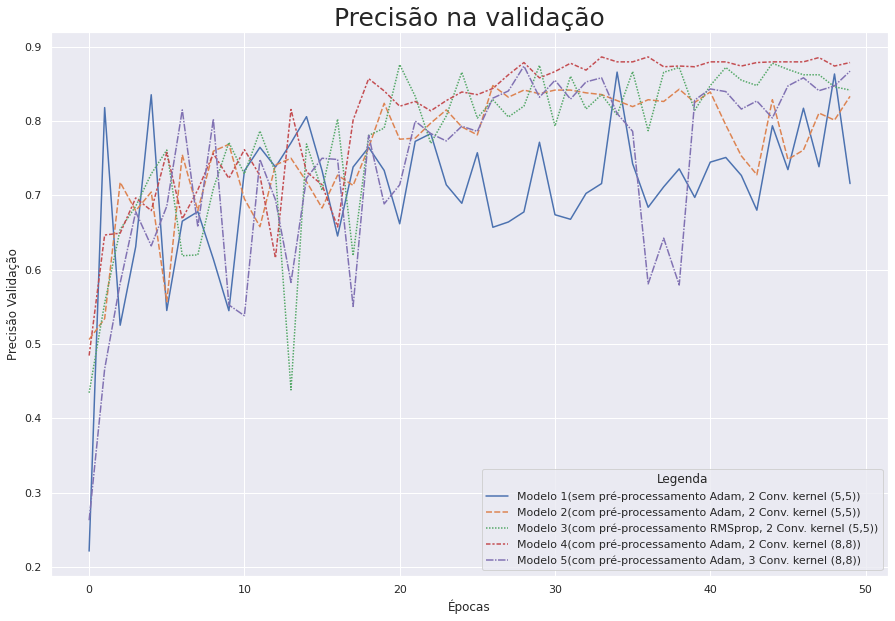

In [43]:
# plotando o gráfico das acurácias no treino
sns.lineplot(data = df_history_modelos,
             x = 'Épocas', 
             y = 'Precisão Validação',
             hue = 'Legenda',
             style='Legenda').set_title('Precisão na validação',fontsize=25)

Como a acurácia foi bastante parecida para todos os modelos (menos a acurácia do modelo 1, mas ela nçao pe tão confiável, pois é muito errática), decidiu-se olhar a métrica da precisão como desempate. Assim, de acordo com o gráfico da precisão, tivemos que o melhor modelo foi o 4, pois ele manteve a melhor precisão após a época 30 (E aqui achamos que os gráficos para precisão de cada modelo esta instável, pois existem poucas observações no conjunto de validação e menos ainda que são efetivamente vulcões).